In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import os
import torch.onnx
import pandas as pd
import matplotlib.pyplot as plt
from fastai.widgets import *
%matplotlib inline

### 1.加载数据

In [2]:
# 加载数据
path = 'data/train/'
df = pd.DataFrame()
image = []
label = []
for each_file in os.listdir(path):

    image.append(os.path.join(each_file))
    label.append(0 if 'cat' in each_file else 1)
df['image'] = image
df['label'] = label

##### 对图片使用默认的transforms:ds_tfms=get_transforms(),并进行标准化操作。

In [3]:
ospath = os.getcwd()

In [8]:
data = ImageDataBunch.from_df(path=os.path.join(ospath,'data'),
                                    folder='train',
                                    df=df,
                                    ds_tfms=get_transforms(),
                                    size =224,
                                    test = 'test',
                                    bs=64).normalize(imagenet_stats) 

### 2.训练模型
##### 使用预训练的resnet50模型，通过lr_find寻找最佳学习率并进行训练。

#### 2.1 使用data_large训练

In [9]:
#加载预训练模型,使用224*224图片
learn = cnn_learner(data, models.resnet50, pretrained=False, metrics=error_rate)
learn.load('resnet50');
learn.freeze()

##### 找到适合的学习率训练模型。参考fastai官方文档https://docs.fast.ai/basic_train.html#Learner

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 6.92E-03


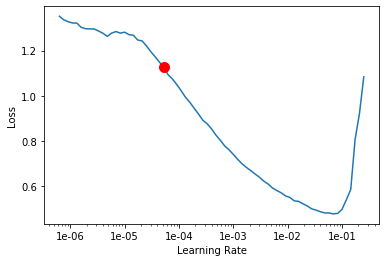

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
learn.fit(3, 5E-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.097037,0.057393,0.020600,02:35
1,0.085310,0.092543,0.035200,02:34
2,0.075743,0.059566,0.021200,02:34


In [ ]:
recorder_fit = learn.recorder

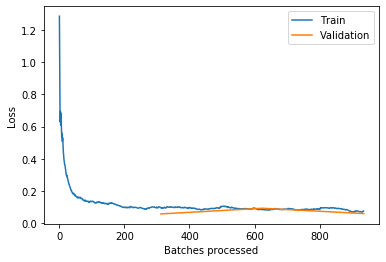

In [93]:
recorder_fit.plot_losses()

In [17]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)
pred_list = preds.numpy()[:,1]

In [21]:
def to_csvfile(x,pred_list,path):
    idx_list = []
    for file in x.items:
        idx = int(file.name.split('.')[0])
        idx_list.append(idx)
    res = pd.DataFrame({'id': idx_list, 'label': pred_list})
    res.sort_values(by='id', inplace=True)
    res.reset_index(drop=True, inplace=True)
    res.to_csv(path, index=False)

In [19]:
path = 'csv/fit.csv'
to_csvfile(learn.data.test_ds.x, pred_list, path)

#### fit_one_cycle

In [10]:
learn.load('resnet50');
learn.freeze()
learn.fit_one_cycle(3, 5E-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.100908,0.065035,0.023400,02:39
1,0.067729,0.069583,0.024800,02:33
2,0.034488,0.026082,0.010000,02:37


In [ ]:
recorder_fit_one_cycle = learn.recorder

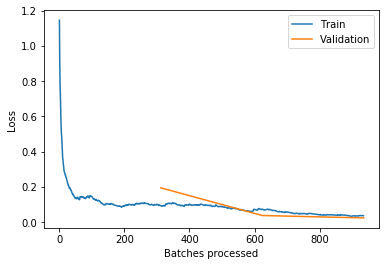

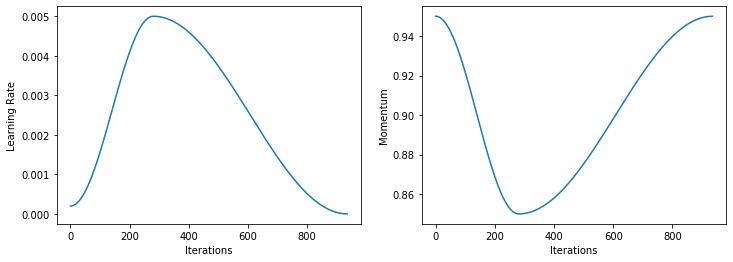

In [103]:
recorder_fit_one_cycle.plot_losses()
recorder_fit_one_cycle.plot_lr(show_moms=True)

In [128]:
learn.save('fit_one_cycle_freeze')

In [46]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)
pred_list = preds.numpy()[:,1]

In [47]:
path = 'csv/fit_one_cycle.csv'
to_csvfile(learn.data.test_ds.x, pred_list, path)

#### 解冻，训练所有层

In [129]:
learn.load('fit_one_cycle_freeze')
learn.unfreeze()
learn.fit_one_cycle(3, 5E-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.590096,0.551309,0.278800,03:23
1,0.684599,0.752236,0.351000,03:24
2,0.547476,0.559449,0.262000,03:24


In [11]:
learn.load('fit_one_cycle_freeze')
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-04
Min loss divided by 10: 4.79E-07


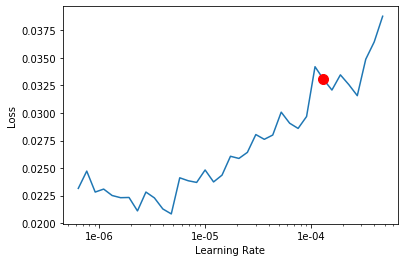

In [130]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [12]:
learn.fit_one_cycle(3, max_lr=slice(1E-5,5E-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.056221,0.034016,0.013800,03:24
1,0.029487,0.020013,0.008800,03:22
2,0.020448,0.015666,0.007200,03:25


In [13]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)
pred_list = preds.numpy()[:,1]

In [22]:
path = 'csv/fit_one_cycle_unfreeze.csv'
to_csvfile(learn.data.test_ds.x, pred_list, path)

In [23]:
learn.save('fit_one_cycle_unfreeze')

### 观察训练集和验证集上损失最大的图像
___
#### 查看训练集上损失最大的数据


In [27]:
#learn = cnn_learner(data, models.resnet50, pretrained=False, metrics=error_rate)
learn.load('fit_one_cycle_unfreeze')
learn.unfreeze()

In [28]:
preds,y,losses = learn.get_preds(ds_type=DatasetType.Train, with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses, ds_type=DatasetType.Train)

In [29]:
top = interp.top_losses()
toplist = top.indices.numpy()
valuelist = top.values.numpy()

In [36]:
valuelist.mean(),valuelist[valuelist<1].mean(),valuelist[valuelist<0.5].mean()

(0.010668447, 0.005784055, 0.0041273497)

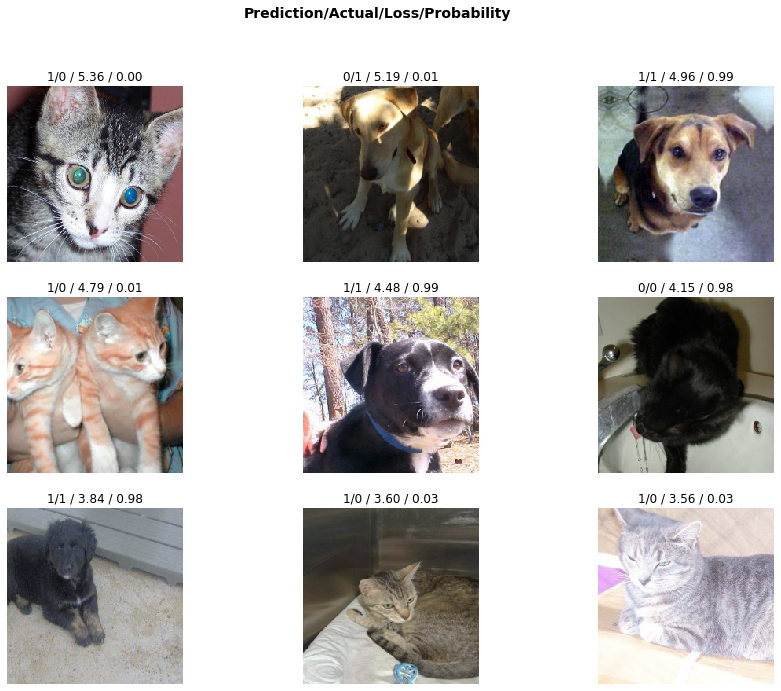

In [31]:
interp.plot_top_losses(9, figsize=(15,11))

 loss > 1 numbers: 43


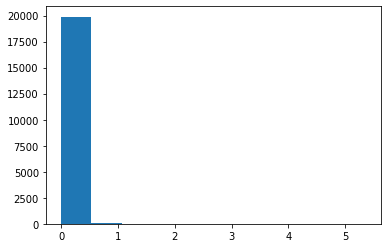

In [35]:
plt.hist(valuelist);
print(' loss > 1 numbers:', len(valuelist[valuelist > 1]))

In [37]:
ImageCleaner(data.train_ds,toplist,'cleaned')

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [38]:
deletelist = toplist[:43]
df_train = pd.read_csv('cleaned/cleaned.csv', header='infer')
df_train_cleaned = df_train.drop(deletelist)

In [39]:
df_train_cleaned['name'] = df_train_cleaned['name'].apply(lambda x: x.split('/')[-1])

In [40]:
df_train_cleaned.to_csv('cleaned/df_train_cleaned.csv')

#### 查看验证集上损失最大的数据 
___

In [42]:
preds,y,losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses, ds_type=DatasetType.Valid)

In [43]:
top = interp.top_losses()
toplist = top.indices.numpy()
valuelist = top.values.numpy()

In [51]:
valuelist.mean(),valuelist[valuelist<1].mean(),valuelist[valuelist<0.5].mean()

(0.015665917, 0.006853298, 0.00395716)

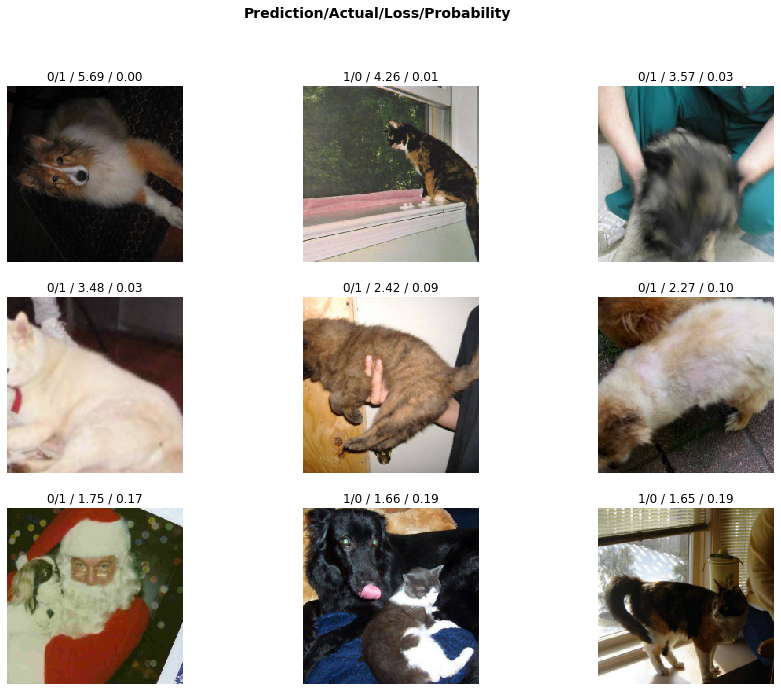

In [44]:
interp.plot_top_losses(9, figsize=(15,11))

 loss > 1 numbers: 23


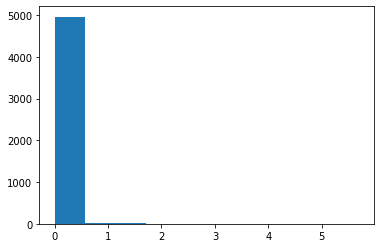

In [45]:
plt.hist(valuelist);
print(' loss > 1 numbers:', len(valuelist[valuelist > 1]))

In [47]:
ImageCleaner(data.valid_ds,toplist,'cleaned')

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [48]:
deletelist = toplist[:23]
df_valid = pd.read_csv('cleaned/cleaned.csv', header='infer')
df_valid_cleaned = df_valid.drop(deletelist)

In [49]:
df_valid_cleaned['name'] = df_valid_cleaned['name'].apply(lambda x: x.split('/')[-1])
df_valid_cleaned.head(3)

,name,label
0,dog.3940.jpg,1
1,dog.11688.jpg,1
2,cat.1006.jpg,0


In [50]:
df_valid_cleaned.to_csv('cleaned/df_valid_cleaned.csv')